<a href="https://colab.research.google.com/github/gavbdheiver/complex_demand_forecasting/blob/main/GB_demand_forecasting_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# packages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from math import sqrt
from numpy import concatenate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# data import
demo = pd.read_csv('/content/demographics.csv')
event = pd.read_csv('/content/event_calendar.csv')
event['YearMonth']  = pd.to_datetime(event['YearMonth'],format='%Y%m')
historical = pd.read_csv('/content/historical_volume.csv')
historical['YearMonth'] = pd.to_datetime(historical['YearMonth'],format='%Y%m')
soda = pd.read_csv('/content/industry_soda_sales.csv')
soda['YearMonth'] = pd.to_datetime(soda['YearMonth'],format='%Y%m')
industry = pd.read_csv('/content/industry_volume.csv')
industry['YearMonth'] = pd.to_datetime(industry['YearMonth'],format='%Y%m')
price = pd.read_csv('/content/price_sales_promotion.csv')
price['YearMonth'] = pd.to_datetime(price['YearMonth'],format='%Y%m')
weather = pd.read_csv('/content/weather.csv')
weather['YearMonth'] = pd.to_datetime(weather['YearMonth'],format='%Y%m')

In [2]:
sku = historical.merge(price,on=['Agency','SKU','YearMonth'],how='left')
sku = sku.merge(soda,on=['YearMonth'],how='left')
sku = sku.merge(industry,on='YearMonth',how='left')
sku = sku.merge(event,on=['YearMonth'],how='left')
print(sku.shape)
sku.head()

(21000, 21)


,Agency,SKU,YearMonth,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,Agency_22,SKU_01,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
1,Agency_22,SKU_02,2013-01-01,110.7000,1167.000000,1067.257500,99.742500,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
2,Agency_58,SKU_23,2013-01-01,0.0000,0.000000,0.000000,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
3,Agency_48,SKU_07,2013-01-01,28.3200,1143.503390,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
4,Agency_22,SKU_05,2013-01-01,238.5387,1310.176057,1203.875711,106.300346,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0


In [3]:
agency = weather.merge(demo,on=['Agency'],how='left')
print(agency.shape)
agency.head()

(3600, 5)


,YearMonth,Agency,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,2013-01-01,Agency_01,17.072,153733,120207
1,2013-02-01,Agency_01,19.984,153733,120207
2,2013-03-01,Agency_01,24.600,153733,120207
3,2013-04-01,Agency_01,27.532,153733,120207
4,2013-05-01,Agency_01,29.396,153733,120207


In [4]:
agency.describe()

,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017
count,3600.000000,3.600000e+03,3600.000000
mean,28.722767,9.367166e+05,148119.333333
std,4.021126,9.131855e+05,50188.108577
min,16.731034,1.227100e+04,90240.000000
25%,25.581118,5.034000e+04,106160.750000
50%,28.648529,6.473045e+05,129333.000000
75%,31.676744,1.719314e+06,204560.750000
max,45.290476,3.137874e+06,247220.000000


In [5]:
df = sku.merge(agency,on=['YearMonth','Agency'],how='left')
print(df.shape)
df.head()

(21000, 24)


,Agency,SKU,YearMonth,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,Agency_22,SKU_01,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110
1,Agency_22,SKU_02,2013-01-01,110.7000,1167.000000,1067.257500,99.742500,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110
2,Agency_58,SKU_23,2013-01-01,0.0000,0.000000,0.000000,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,1620969,105857
3,Agency_48,SKU_07,2013-01-01,28.3200,1143.503390,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.052893,1739969,210213
4,Agency_22,SKU_05,2013-01-01,238.5387,1310.176057,1203.875711,106.300346,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110


In [6]:
df = pd.get_dummies(df, columns= ['SKU'], dummy_na= False)
df.head()

,Agency,YearMonth,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
0,Agency_22,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agency_22,2013-01-01,110.7000,1167.000000,1067.257500,99.742500,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agency_58,2013-01-01,0.0000,0.000000,0.000000,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,1620969,105857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Agency_48,2013-01-01,28.3200,1143.503390,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.052893,1739969,210213,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Agency_22,2013-01-01,238.5387,1310.176057,1203.875711,106.300346,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
df.describe()

,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
count,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.0,21000.0,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,1451.536344,1267.347450,184.374146,8.512000e+08,5.439214e+08,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.016667,0.0,0.0,0.083333,0.083333,28.612404,1.045065e+06,151073.494286,0.148571,0.148571,0.162857,0.165714,0.148571,0.011429,0.040000,0.020000,0.008571,0.002857,0.011429,0.005714,0.022857,0.011429,0.005714,0.028571,0.005714,0.022857,0.002857,0.002857,0.002857,0.002857,0.002857,0.008571,0.005714
std,2711.496882,683.362417,587.757323,257.469968,7.824340e+07,6.288022e+07,0.276392,0.276392,0.276392,0.276392,0.276392,0.276392,0.276392,0.128022,0.0,0.0,0.276392,0.276392,3.972833,9.291926e+05,50409.593114,0.355674,0.355674,0.369244,0.371833,0.355674,0.106294,0.195964,0.140003,0.092187,0.053377,0.106294,0.075378,0.149452,0.106294,0.075378,0.166603,0.075378,0.149452,0.053377,0.053377,0.053377,0.053377,0.053377,0.092187,0.075378
min,0.000000,0.000000,-3121.690141,0.000000,6.964015e+08,4.130518e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,16.731034,1.227100e+04,90240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.272388,1311.547158,1178.365653,54.935108,7.890880e+08,5.090553e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,25.374816,6.018900e+04,110057.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,158.436000,1495.174592,1324.695706,138.307225,8.649196e+08,5.512000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,28.479272,1.232242e+06,131411.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1774.793475,1725.652080,1517.311427,272.298630,9.005551e+08,5.893715e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,31.568405,1.729177e+06,206553.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,22526.610000,19166.625000,4925.404000,19166.625000,1.049869e+09,6.700157e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,45.290476,3.137874e+06,247220.000000,1.000000,1.000

In [8]:
train_df = df.drop(columns=['Price','Sales','Promotions'])
train_df.set_index('YearMonth',inplace=True)
train_df.head()

,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_22,52.2720,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_22,110.7000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_58,0.0000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,1620969,105857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-01,Agency_48,28.3200,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.052893,1739969,210213,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_22,238.5387,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
test = pd.read_csv('/content/volume_forecast.csv')
print(test.shape)
test.head()

(1450, 3)


,Agency,SKU,Volume
0,Agency_23,SKU_06,NaN
1,Agency_34,SKU_20,NaN
2,Agency_24,SKU_02,NaN
3,Agency_40,SKU_06,NaN
4,Agency_42,SKU_32,NaN


In [10]:
n_date = len(train_df.index.unique())
tes4 = pd.date_range(start='1/1/2013', end='31/12/2017',freq='M')
tes3 = list(tes4)*len(test)
tes1 = list(test.Agency)*len(tes4)
tes2 = list(test.SKU)*len(tes4)

In [11]:
test_df = pd.DataFrame({'Agency':tes1,'SKU':tes2,'Volume':np.nan})
test_df.sort_values(['Agency','SKU'],inplace=True,ascending=False)
test_df.reset_index(inplace=True,drop=True)
test_df.loc[:,'YearMonth'] = tes3
test_df['YearMonth'] = test_df['YearMonth'].dt.floor('d') - pd.offsets.MonthBegin(1)
print(test_df.shape)
test_df.head()

(87000, 4)


,Agency,SKU,Volume,YearMonth
0,Agency_60,SKU_34,NaN,2013-01-01
1,Agency_60,SKU_34,NaN,2013-02-01
2,Agency_60,SKU_34,NaN,2013-03-01
3,Agency_60,SKU_34,NaN,2013-04-01
4,Agency_60,SKU_34,NaN,2013-05-01


In [12]:
test_df = test_df.merge(weather,on=['YearMonth','Agency'],how='left')
test_df = test_df.merge(demo,on='Agency',how='left')
test_df = test_df.merge(industry,on='YearMonth',how='left')
test_df = test_df.merge(soda,on=['YearMonth'],how='left')
test_df = test_df.merge(event,on=['YearMonth'],how='left')
test_df = pd.get_dummies(test_df, columns= ['SKU'], dummy_na= False)
test_df.set_index('YearMonth',inplace=True)
test_df = test_df[train_df.columns]
print(test_df.shape)
test_df.head()

(87000, 44)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_60,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-02-01,Agency_60,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-03-01,Agency_60,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,0,0,1,24.925652,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-01,Agency_60,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-05-01,Agency_60,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,0,0,27.555022,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
tes = ['Agency_06','Agency_14']*len(price.SKU.unique())*len(tes4)
tes.sort()
tes5 = list(price.SKU.unique())*2*len(tes4)
df_agen = pd.DataFrame({'Agency':tes,'SKU':tes5,'YearMonth':np.NaN,'Volume':np.NaN})
df_agen.sort_values(['Agency','SKU'],inplace=True)
df_agen.loc[:,'YearMonth'] = list(tes4)*2*25
df_agen.loc[:,'YearMonth'] = df_agen.loc[:,'YearMonth'].dt.floor('d') - pd.offsets.MonthBegin(1)
print(df_agen.shape)
df_agen.head()

(3000, 4)


,Agency,SKU,YearMonth,Volume
0,Agency_06,SKU_01,2013-01-01,NaN
25,Agency_06,SKU_01,2013-02-01,NaN
50,Agency_06,SKU_01,2013-03-01,NaN
75,Agency_06,SKU_01,2013-04-01,NaN
100,Agency_06,SKU_01,2013-05-01,NaN


In [14]:
df_agen = df_agen.merge(weather,on=['YearMonth','Agency'],how='left')
df_agen = df_agen.merge(demo,on='Agency',how='left')
df_agen = df_agen.merge(industry,on='YearMonth',how='left')
df_agen = df_agen.merge(soda,on=['YearMonth'],how='left')
df_agen = df_agen.merge(event,on=['YearMonth'],how='left')
df_agen = pd.get_dummies(df_agen, columns= ['SKU'], dummy_na= False)
df_agen.set_index('YearMonth',inplace=True)
df_agen = df_agen[train_df.columns]
print(df_agen.shape)
df_agen.head()

(3000, 44)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_06,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.079012,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-02-01,Agency_06,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,0,0,28.416049,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-01,Agency_06,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,0,0,1,28.715493,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-04-01,Agency_06,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,0,0,32.113750,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-05-01,Agency_06,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,0,0,32.577215,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [16]:
# Missing values statistics
missing_values = missing_values_table(train_df)

Your selected dataframe has 44 columns.
There are 0 columns that have missing values.


In [17]:
# Missing values statistics
missing_values = missing_values_table(test_df)
missing_values.head()

Your selected dataframe has 44 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Volume,87000,100.0


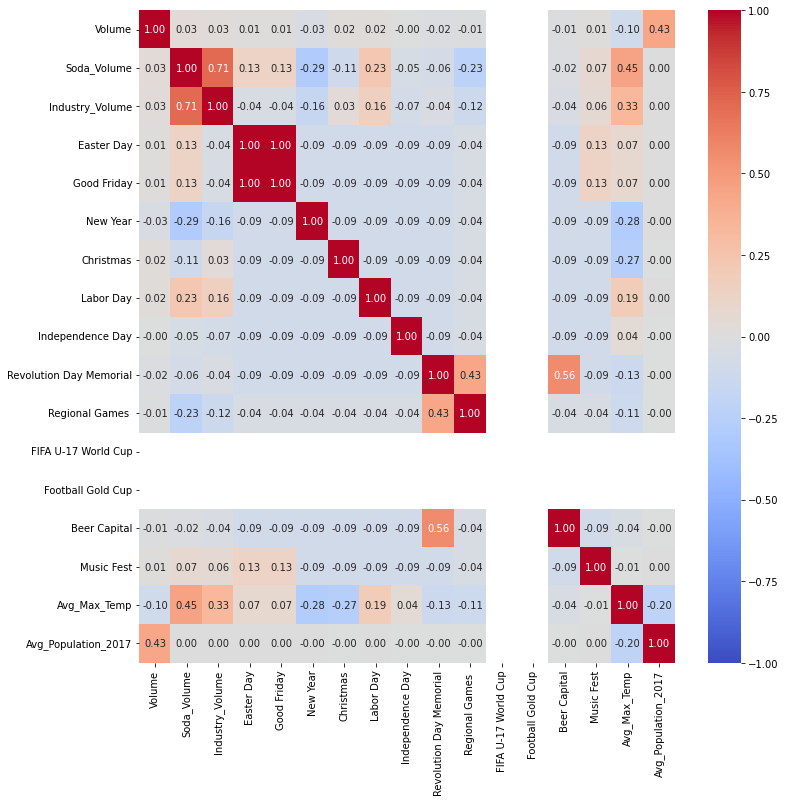

In [18]:
corr = train_df[train_df.columns[:18]].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,vmin=-1,cmap='coolwarm', annot=True, fmt = ".2f")

In [19]:
train_df.drop(columns=['FIFA U-17 World Cup','Football Gold Cup'],inplace=True)
test_df.drop(columns=['FIFA U-17 World Cup','Football Gold Cup'],inplace=True)
df_agen.drop(columns=['FIFA U-17 World Cup','Football Gold Cup'],inplace=True)

In [20]:
x_call = train_df.columns[2:]
X = train_df[x_call]
y = train_df['Volume']

In [21]:
std_call = ['Soda_Volume','Industry_Volume','Avg_Max_Temp','Avg_Population_2017','Avg_Yearly_Household_Income_2017']
scaller = StandardScaler()
std = pd.DataFrame(scaller.fit_transform(X[std_call]),columns=std_call)
std_test = pd.DataFrame(scaller.transform(test_df[std_call]),columns=std_call)
std_agen = pd.DataFrame(scaller.transform(df_agen[std_call]),columns=std_call)

In [22]:
X_std = X.copy()
X_std.loc[:,std_call] = std.values
test_df_std = test_df.copy() 
df_agen_std = df_agen.copy()
test_df_std.loc[:,std_call] = std_test.values 
df_agen_std.loc[:,std_call] = std_agen.values

In [23]:
print(X_std.shape)
X_std.head()

(21000, 40)


,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-0.696539,-1.072907,-0.376197,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-0.696539,-1.072907,-0.376197,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-1.609134,0.619805,-0.897003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-1.147700,0.747876,1.173208,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-0.696539,-1.072907,-0.376197,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.30, random_state = 217,shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14700, 40)
(14700,)
(6300, 40)
(6300,)


In [25]:
# Spot all methods want to be used
models = []
models.append(('RF', RandomForestRegressor()))
models.append(('LR', LinearRegression()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('LG', LGBMRegressor()))
models.append(('KN', KNeighborsRegressor()))
models.append(('XG', XGBRegressor(objective='reg:squarederror')))

In [26]:
results = pd.DataFrame({'Score':['fit_time', 'score_time', 'test_R_Square', 'test_MSE', 'test_MAE']})
for name, model in models:
    # Spot all scorers want to be used
    scorer = {'R_Square' : 'r2',
              'MSE'  : 'neg_mean_squared_error',
              'MAE' : 'neg_mean_absolute_error'}
        
    # Cross Validation Model
    kfold = KFold(n_splits=5, random_state=217,shuffle=True)
    cv_results = cross_validate(model,X_train, y_train,cv=kfold,scoring=scorer)
    cv_results['test_R_Square'] = cv_results['test_R_Square']*100
    cv_results['test_MSE'] = np.log(np.sqrt(np.abs(cv_results['test_MSE'])))*10
    cv_results['test_MAE'] = np.log(np.abs(cv_results['test_MAE']))*10
    results[name] = pd.DataFrame(cv_results).mean().values

In [27]:
results

,Score,RF,LR,GB,LG,KN,XG
0,fit_time,5.298090,0.033845,1.477287,0.189396,0.008266,1.261379
1,score_time,0.111218,0.005226,0.008590,0.015326,0.750232,0.010484
2,test_R_Square,95.637012,41.451708,66.156521,94.634654,58.453870,65.960436
3,test_MSE,63.277215,76.269354,73.529137,64.318615,74.551363,73.556059
4,test_MAE,54.698385,71.741095,67.690330,57.674629,67.668241,67.707385


In [28]:
model_rf = RandomForestRegressor()

model_rf.fit(X_train, y_train)

predictions = model_rf.predict(X_test)
print("R Square: %.3f" % r2_score(y_test, predictions))
print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, predictions)))
print("MAE: %f" % mean_absolute_error(y_test, predictions))

R Square: 0.955
RMSE: 589.793676
MAE: 236.583510


In [29]:
model_lg = LGBMRegressor()

model_lg.fit(X_train, y_train)

predictions = model_lg.predict(X_test)
print("R Square: %.3f" % r2_score(y_test, predictions))
print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, predictions)))
print("MAE: %f" % mean_absolute_error(y_test, predictions))

R Square: 0.947
RMSE: 636.167995
MAE: 320.039405


In [30]:
model_fix = RandomForestRegressor()
model_fix.fit(X_std, y)

RandomForestRegressor()

In [31]:
def plot_feature_importances(df,n):
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (12, 12))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:n]))), 
            df['importance_normalized'].head(n), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:n]))))
    ax.set_yticklabels(df['feature'].head(n))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [32]:
# Extract feature importances
feature_importance = model_fix.feature_importances_
feature_importances = pd.DataFrame({'feature': x_call, 'importance': feature_importance})

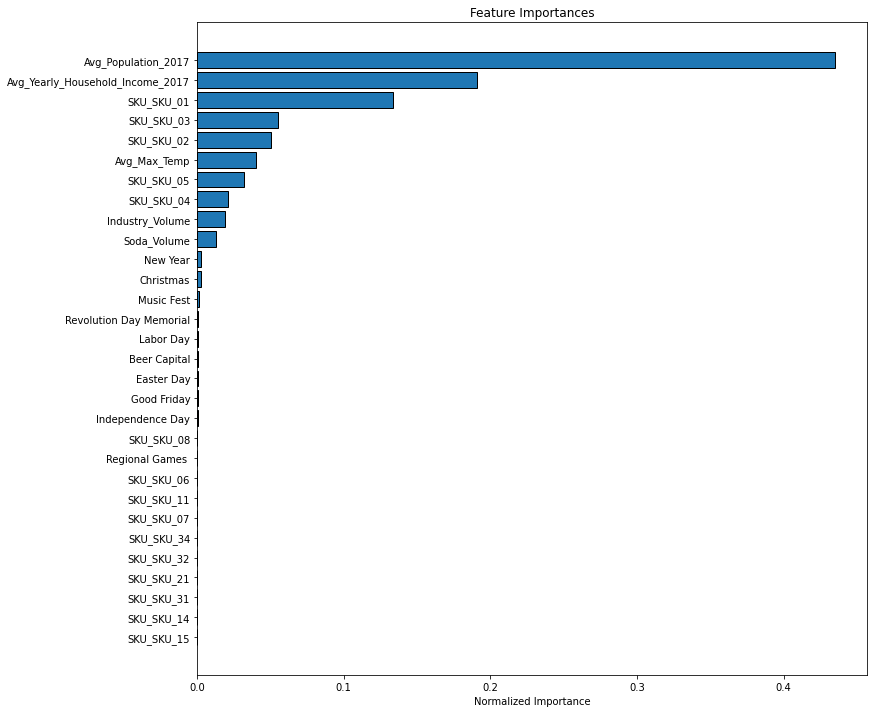

In [33]:
feature_importance = plot_feature_importances(feature_importances,30)

In [34]:
print(test_df.shape)
test_df.head()

(87000, 42)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_60,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,22.219737,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-02-01,Agency_60,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-03-01,Agency_60,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,1,24.925652,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-01,Agency_60,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-05-01,Agency_60,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,27.555022,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [35]:
pred_test = model_fix.predict(test_df_std[x_call])
test_df.loc[:,'Volume'] = pred_test
print(test_df.shape)
test_df.head()

(87000, 42)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_60,23.877300,718394219,492612703,0,0,1,0,0,0,0,0,0,0,22.219737,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-02-01,Agency_60,4.425000,753938444,431937346,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-03-01,Agency_60,5.159550,892192092,509281531,1,1,0,0,0,0,0,0,0,1,24.925652,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-01,Agency_60,7.226025,838099501,532390389,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-05-01,Agency_60,17.823900,864420003,551755254,0,0,0,0,1,0,0,0,0,0,27.555022,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [36]:
def split(x):
    x = x.split('_')
    return x[1]+'_'+x[2]

test_df.loc[:,'SKU'] = test_df[test_df.columns[17:]].idxmax(axis=1).apply(split).values

In [37]:
test_df.drop(columns=test_df.iloc[:,17:-1].columns,inplace=True)
test_df.reset_index(inplace=True)
print(test_df.shape)
test_df.head()

(87000, 19)


,YearMonth,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU
0,2013-01-01,Agency_60,23.877300,718394219,492612703,0,0,1,0,0,0,0,0,0,0,22.219737,2180611,211936,SKU_34
1,2013-02-01,Agency_60,4.425000,753938444,431937346,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,SKU_34
2,2013-03-01,Agency_60,5.159550,892192092,509281531,1,1,0,0,0,0,0,0,0,1,24.925652,2180611,211936,SKU_34
3,2013-04-01,Agency_60,7.226025,838099501,532390389,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,SKU_34
4,2013-05-01,Agency_60,17.823900,864420003,551755254,0,0,0,0,1,0,0,0,0,0,27.555022,2180611,211936,SKU_34


In [38]:
pivot = pd.pivot_table(test_df, values='Volume', index='YearMonth', columns=['Agency','SKU'])
print(pivot.shape)
pivot.head()

(60, 1450)


Agency      Agency_01                                                          \
SKU            SKU_01     SKU_02     SKU_03      SKU_04     SKU_05     SKU_06   
YearMonth                                                                       
2013-01-01   71.75952   68.75712  35.419320  206.919702  16.405713  20.105346   
2013-02-01   96.09408   89.05788  45.654390  254.693259  16.741542  27.439371   
2013-03-01  115.91640  107.23428  49.769626  351.980391  27.769269  36.040512   
2013-04-01  131.81832  121.77324  61.375513  337.119733  24.020343  36.174854   
2013-05-01  144.87012  151.57368  68.250204  416.746854  27.593298  42.456615   

Agency                                                                        \
SKU            SKU_07     SKU_08     SKU_11     SKU_12     SKU_14     SKU_15   
YearMonth                                                                      
2013-01-01  20.105346  11.572701   8.260353  20.105346  20.105346  20.105346   
2013-02-01  27.439371  13.192383  11.470464  27.439371  27.439371  27.439371   
2013-03-01  36.040512  16.587030  18.261690  36.040512  36.040512  36.040512   
2013-04-01  36.174854  15.027694  15.216378  36.174854  36.174854  36.174854   
2013-05-01  42.456615  17.480298  19.665165  42.456615  42.456615  42.456615   

Agency                                                                        \
SKU            SKU_17     SKU_18     SKU_20     SKU_21     SKU_22     SKU_23   
YearMonth                                                                      
2013-01-01  20.105346  20.105346  20.105346  20.105346  20.105346  20.105346   
2013-02-01  27.439371  27.439371  27.439371  27.439371  27.439371  27.439371   
2013-03-01  36.040512  36.040512  36.040512  36.040512  36.040512  36.040512   
2013-04-01  36.174854  36.174854  36.174854  36.174854  36.174854  36.174854   
2013-05-01  42.456615  42.456615  42.456615  42.456615  42.456615  42.456615   

Agency                                                                        \
SKU            SKU_24     SKU_26     SKU_27     SKU_28     SKU_31     SKU_32   
YearMonth                                                                      
2013-01-01  20.105346  20.105346  20.105346  20.105346  20.105346  20.105346   
2013-02-01  27.439371  27.439371  27.439371  27.439371  27.439371  27.439371   
2013-03-01  36.040512  36.040512  36.040512  36.040512  36.040512  36.040512   
2013-04-01  36.174854  36.174854  36.174854  36.174854  36.174854  36.174854   
2013-05-01  42.456615  42.456615  42.456615  42.456615  42.456615  42.456615   

Agency                   Agency_02                                           \
SKU            SKU_34       SKU_01        SKU_02        SKU_03       SKU_04   
YearMonth                                                                     
2013-01-01  20.105346  6450.362820   7546.207305   8462.567658  4772.057102   
2013-02-01  27.439371  7156.107180   8549.489715  10170.998457  5273.907156   
2013-03-01  36.040512  8534.251680  10583.258850  11844.286875  6897.483243   
2013-04-01  36.174854  9226.284375  11052.224010  11413.408500  6039.212070   
2013-05-01  42.456615  9505.185000  12228.056640  12432.772500  7052.387835   

Agency                                                                 \
SKU              SKU_05      SKU_06      SKU_07      SKU_08    SKU_11   
YearMonth                                                               
2013-01-01  2376.610344   78.382200   75.197550  158.627916  0.000000   
2013-02-01  2654.577266   78.312480   91.506450  185.436522  0.000000   
2013-03-01  3182.123099   71.917125  108.664725  233.992694  0.163743   
2013-04-01  3363.110668  123.881874  102.718050  240.161156  0.055575   
2013-05-01  3806.683973   82.892214  111.350700  301.741836  0.000000   

Agency                                                                  \
SKU             SKU_12      SKU_14      SKU_15      SKU_17      SKU_18   
YearMonth                                                     

In [39]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [40]:
dataset = np.array(pivot)
# choose a number of time steps
n_steps = 12
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

In [41]:
# split into train and validating
train_X, train_y = X[:-12, :], y[:-12,:]
val_X, val_y = X[-12:-3, :], y[-12:-3,:]
test_X, test_y = X[-3:, :], y[-3:,:]

In [42]:
# define model
model = Sequential()
model.add(LSTM(1024, activation='relu', return_sequences=True, input_shape=(n_steps, n_features),recurrent_dropout=0.2))
model.add(LSTM(512, activation='relu',return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(256, activation='relu',return_sequences=True,recurrent_dropout=0.1))
model.add(LSTM(128, activation='relu',recurrent_dropout=0.1))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse') 

In [91]:
# fit model
#history = model.fit(train_X, train_y, epochs=712, batch_size=32, verbose=0, shuffle=False,validation_data=(val_X, val_y))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 1024)          10137600  
                                                                 
 lstm_1 (LSTM)               (None, 12, 512)           3147776   
                                                                 
 lstm_2 (LSTM)               (None, 12, 256)           787456    
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 1450)              187050    
                                                                 
Total params: 14,457,002
Trainable params: 14,457,002
Non-trainable params: 0
_________________________________________________________________


In [45]:
    from keras.models import load_model
    
    model.save('my_model1.h5')  # creates a HDF5 file 'my_model.h5'
    del model  # deletes the existing model
    
    # returns a compiled model
    # identical to the previous one
    model = load_model('my_model1.h5')

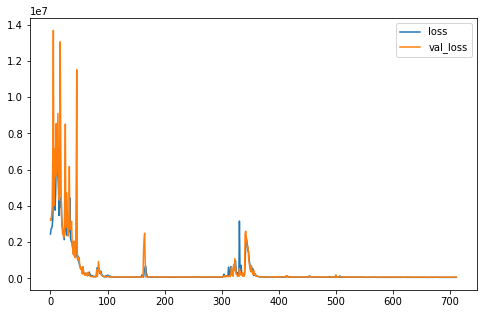

In [46]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [51]:
import datetime as dt 
import plotly
import plotly.graph_objs as go

# Declare plotly figure (go)
fig=go.Figure()

fig.add_trace(go.Scatter(
                x=list(range(1,722)),
                y=history.history['loss'],
                name="Train",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=list(range(1,722)),
                y=history.history['val_loss'],
                name="Test",
                line_color='dimgray',
                opacity=0.8))

# Use date string to set xaxis range
fig.layout.update(title_text="Forecasting Score")
fig.show

<bound method BaseFigure.show of Figure({
    'data': [{'line': {'color': 'deepskyblue'},
              'name': 'Train',
              'opacity': 0.8,
              'type': 'scatter',
              'x': [1, 2, 3, ..., 719, 720, 721],
              'y': [2443161.75, 2729148.0, 2762571.0, ..., 54208.91015625,
                    54576.1875, 53969.95703125]},
             {'line': {'color': 'dimgray'},
              'name': 'Test',
              'opacity': 0.8,
              'type': 'scatter',
              'x': [1, 2, 3, ..., 719, 720, 721],
              'y': [3277164.25, 3191551.5, 3496291.0, ..., 65613.65625,
                    63806.3671875, 64552.20703125]}],
    'layout': {'template': '...', 'title': {'text': 'Forecasting Score'}}
})>

In [52]:
# demonstrate prediction
train_yhat = model.predict(train_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(train_y,train_yhat)))

RMSE of training data : 221.531


In [53]:
# demonstrate prediction
val_yhat = model.predict(val_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(val_y,val_yhat)))

RMSE of training data : 254.071


In [54]:
# demonstrate prediction
test_yhat = model.predict(test_X, verbose=0)
print("RMSE of testing data : %.3f" % np.sqrt(mean_squared_error(test_y,test_yhat)))

RMSE of testing data : 313.457


In [55]:
# demonstrate prediction
x_input = X[len(X)-1,:]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

In [56]:
pivot.loc['2018-01-01',:] = yhat
pivot.index = pd.to_datetime(pivot.index)

In [57]:
vol_for = pd.read_csv('/content/volume_forecast.csv')
print(vol_for.shape)
vol_for.head()

(1450, 3)


,Agency,SKU,Volume
0,Agency_23,SKU_06,NaN
1,Agency_34,SKU_20,NaN
2,Agency_24,SKU_02,NaN
3,Agency_40,SKU_06,NaN
4,Agency_42,SKU_32,NaN


In [58]:
def volume(row):
    agen = row.Agency
    cost = row.SKU
    return pivot[agen,cost]['2018-01-01']

vol_for['Volume'] = vol_for.apply(volume,axis=1)
print(vol_for.shape)

(1450, 3)


In [ ]:
vol_for.head(20)

In [60]:
vol_for.tail(20)

,Agency,SKU,Volume
1430,Agency_01,SKU_22,10.640542
1431,Agency_42,SKU_04,151.978699
1432,Agency_46,SKU_20,10.772633
1433,Agency_50,SKU_02,13354.684570
1434,Agency_19,SKU_15,1.028529
1435,Agency_07,SKU_34,28.876320
1436,Agency_29,SKU_27,11.847974
1437,Agency_51,SKU_15,5.906641
1438,Agency_26,SKU_11,3.972649
1439,Agency_43,SKU_24,383.499512


In [61]:
df_agen.head()

,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_06,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,24.079012,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-02-01,Agency_06,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,28.416049,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-01,Agency_06,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,1,28.715493,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-04-01,Agency_06,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,32.113750,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-05-01,Agency_06,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,32.577215,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
pred = model_fix.predict(df_agen_std[x_call])
df_agen.loc[:,'Volume'] = pred
print(df_agen.shape)
df_agen.head()

(3000, 42)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_06,3354.331901,718394219,492612703,0,0,1,0,0,0,0,0,0,0,24.079012,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-02-01,Agency_06,4045.120260,753938444,431937346,0,0,0,0,0,0,0,0,0,0,28.416049,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-01,Agency_06,4282.535880,892192092,509281531,1,1,0,0,0,0,0,0,0,1,28.715493,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-04-01,Agency_06,4883.288070,838099501,532390389,0,0,0,0,0,0,0,0,0,0,32.113750,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-05-01,Agency_06,5269.460580,864420003,551755254,0,0,0,0,1,0,0,0,0,0,32.577215,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
df_agen.loc[:,'SKU'] = df_agen[df_agen.columns[17:]].idxmax(axis=1).apply(split).values
df_agen.drop(columns=df_agen.iloc[:,17:-1].columns,inplace=True)
df_agen.reset_index(inplace=True)
print(df_agen.shape)
df_agen.head()

(3000, 19)


,YearMonth,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU
0,2013-01-01,Agency_06,3354.331901,718394219,492612703,0,0,1,0,0,0,0,0,0,0,24.079012,2104390,228353,SKU_01
1,2013-02-01,Agency_06,4045.120260,753938444,431937346,0,0,0,0,0,0,0,0,0,0,28.416049,2104390,228353,SKU_01
2,2013-03-01,Agency_06,4282.535880,892192092,509281531,1,1,0,0,0,0,0,0,0,1,28.715493,2104390,228353,SKU_01
3,2013-04-01,Agency_06,4883.288070,838099501,532390389,0,0,0,0,0,0,0,0,0,0,32.113750,2104390,228353,SKU_01
4,2013-05-01,Agency_06,5269.460580,864420003,551755254,0,0,0,0,1,0,0,0,0,0,32.577215,2104390,228353,SKU_01


In [64]:
pivot_agen = pd.pivot_table(df_agen.reset_index(), values='Volume', index='YearMonth', columns=['Agency','SKU'])
print(pivot_agen.shape)
pivot_agen.head()

(60, 50)


Agency        Agency_06                                                       \
SKU              SKU_01        SKU_02       SKU_03       SKU_04       SKU_05   
YearMonth                                                                      
2013-01-01  3354.331901   6665.444064  2399.473629  2189.596089  1746.748927   
2013-02-01  4045.120260   7422.157395  3364.277746  2289.686181  1992.615195   
2013-03-01  4282.535880   8692.253145  3872.612923  2648.209715  2426.425948   
2013-04-01  4883.288070   9439.176540  4028.688756  2567.255962  2602.946220   
2013-05-01  5269.460580  10348.877550  4328.702259  2583.730755  2565.593884   

Agency                                                                  \
SKU            SKU_06     SKU_07      SKU_08 SKU_11   SKU_12    SKU_14   
YearMonth                                                                
2013-01-01  36.513720  51.967200  204.315777    0.0  2.70600  1.493130   
2013-02-01  35.326800  67.724625  254.264490    0.0  3.02100  0.306294   
2013-03-01  55.477440  80.424375  304.038077    0.0  3.08250  0.428556   
2013-04-01  43.555914  76.494975  312.319642    0.0  3.36525  0.031194   
2013-05-01  65.888154  85.946775  383.133879    0.0  3.87975  0.373176   

Agency                                                                  \
SKU           SKU_15    SKU_17    SKU_18    SKU_20    SKU_21    SKU_22   
YearMonth                                                                
2013-01-01  2.155986  0.000000  0.000000  0.072846  0.000000  0.000000   
2013-02-01  0.990621  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-03-01  3.986508  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-04-01  0.153873  0.003834  0.003834  0.003834  0.003834  0.003834   
2013-05-01  0.706734  0.003834  0.003834  0.170613  0.003834  0.003834   

Agency                                                                  \
SKU           SKU_23    SKU_24    SKU_26    SKU_27    SKU_28    SKU_31   
YearMonth                                                                
2013-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  3.305475   
2013-02-01  0.000000  0.000000  0.000000  0.000000  0.000000  4.708200   
2013-03-01  0.000000  0.000000  0.000000  0.000000  0.000000  3.070950   
2013-04-01  0.003834  0.003834  0.003834  0.003834  0.003834  1.885050   
2013-05-01  0.003834  0.003834  0.003834  0.003834  0.003834  2.986875   

Agency                               Agency_14                           \
SKU             SKU_32     SKU_34       SKU_01       SKU_02      SKU_03   
YearMonth                                                                 
2013-01-01   70.195428   4.278975  6148.788825  5467.843440  630.811446   
2013-02-01   67.765950   4.429425  6907.331873  6821.928300  640.399138   
2013-03-01  119.146578   3.504600  8191.633305  7099.637250  707.178880   
2013-04-01   36.931191  14.965350  7820.508646  6494.283585  868.810605   
2013-05-01   55.440195   9.637650  8420.194208  6863.850810  811.932432   

Agency                                                                       \
SKU              SKU_04      SKU_05    SKU_06     SKU_07      SKU_08 SKU_11   
YearMonth                                                                     
2013-01-01  2174.748308  392.442599  36.47484  46.670475  204.315777    0.0   
2013-02-01  2306.544518  468.099124  30.04884  60.609225  247.806117    0.0   
2013-03-01  2929.174670  511.005646  50.41548  74.521425  296.495307    0.0   
2013-04-01  2389.358736  705.477929  29.88576  72.339900  285.442696    0.0   
2013-05-01  2673.311113  710.137761  56.86308  78.756150  315.768034    0.0   

Agency                                                                     \
SKU         SKU_12    SKU_14    SKU_15 SKU_17 SKU_18 SKU_20 SKU_21 SKU_22   
YearMonth                                                                   
2013-01-01  1.2495  0.585750  2.067378    0.0    0.0    0.0    0.0    0.0   
2013-02-01  1.6410  0.412794  0.544428

In [65]:
dataset = np.array(pivot_agen)
# choose a number of time steps
n_steps = 12
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

In [66]:
# split into train and validating
train_X, train_y = X[:-12, :], y[:-12,:]
val_X, val_y = X[-12:-3, :], y[-12:-3,:]
test_X, test_y = X[-3:, :], y[-3:,:]

In [67]:
# define model
model = Sequential()
# define model
model = Sequential()
model.add(LSTM(1024, activation='relu', return_sequences=True, input_shape=(n_steps, n_features),recurrent_dropout=0.2))
model.add(LSTM(512, activation='relu',return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(256, activation='relu',return_sequences=True,recurrent_dropout=0.1))
model.add(LSTM(128, activation='relu',recurrent_dropout=0.1))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [68]:
# fit model
#history = model.fit(train_X, train_y, epochs=712, batch_size=32, verbose=0, shuffle=False,validation_data=(val_X, val_y))

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 1024)          4403200   
                                                                 
 lstm_5 (LSTM)               (None, 12, 512)           3147776   
                                                                 
 lstm_6 (LSTM)               (None, 12, 256)           787456    
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
Total params: 8,542,002
Trainable params: 8,542,002
Non-trainable params: 0
_________________________________________________________________


In [70]:
    from keras.models import load_model
    
    model.save('my_model2.h5')  # creates a HDF5 file 'my_model.h5'
    del model  # deletes the existing model
    
    # returns a compiled model
    # identical to the previous one
    model = load_model('my_model2.h5')

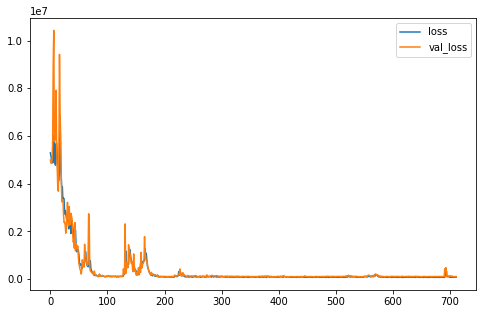

In [71]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [72]:
# demonstrate prediction
train_yhat = model.predict(train_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(train_y,train_yhat)))

RMSE of training data : 288.985


In [73]:
# demonstrate prediction
val_yhat = model.predict(val_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(val_y,val_yhat)))

RMSE of training data : 330.735


In [74]:
# demonstrate prediction
test_yhat = model.predict(test_X, verbose=0)
print("RMSE of testing data : %.3f" % np.sqrt(mean_squared_error(test_y,test_yhat)))

RMSE of testing data : 395.187


In [75]:
# demonstrate prediction
x_input = X[len(X)-1,:]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

In [76]:
pivot_agen.loc['2018-01-01',:] = yhat
pivot_agen.index = pd.to_datetime(pivot_agen.index)
pivot_agen.tail()

Agency        Agency_06                                                      \
SKU              SKU_01       SKU_02       SKU_03       SKU_04       SKU_05   
YearMonth                                                                     
2017-09-01  3593.437560  7299.626790  5198.275770  2302.828232  1535.076948   
2017-10-01  3219.723000  7791.473295  5288.652497  2176.521995  1563.979112   
2017-11-01  2631.360600  6236.471775  5404.135777  1918.538781  1623.964415   
2017-12-01  3498.742080  7192.886280  3952.728552  3113.856870  1594.111555   
2018-01-01  3456.519287  7282.748047  3520.144531  1949.429321  1561.670044   

Agency                                                                        \
SKU            SKU_06     SKU_07      SKU_08     SKU_11    SKU_12     SKU_14   
YearMonth                                                                      
2017-09-01  33.820425  63.768675  215.814328   1.918165  2.488921   1.386611   
2017-10-01  44.555943  66.945825  211.575255   1.967733  2.250603   1.174938   
2017-11-01  39.250959  82.924500  213.653491   1.131892  2.004760   0.857787   
2017-12-01  53.929344  79.689825  240.027278   0.904470  0.997914   1.838647   
2018-01-01  50.573780  99.974075  289.321503  29.519674  1.597737  73.563019   

Agency                                                                      \
SKU            SKU_15    SKU_17     SKU_18    SKU_20     SKU_21     SKU_22   
YearMonth                                                                    
2017-09-01   2.406736  2.802269   1.918165  3.614620   1.996003   1.918165   
2017-10-01   1.957402  2.130777   1.967733  3.691661   2.047884   1.967733   
2017-11-01   1.576110  1.651221   1.131892  4.185072   2.765077   1.131892   
2017-12-01   0.541737  0.943630   0.904470  5.069771   1.075570   0.904470   
2018-01-01  14.792499  5.123398 -16.450321 -9.648664  36.716953  64.502647   

Agency                                                                      \
SKU            SKU_23    SKU_24    SKU_26     SKU_27     SKU_28     SKU_31   
YearMonth                                                                    
2017-09-01   1.529193  2.489447  2.556625   3.109866   1.755801   6.740071   
2017-10-01   1.890646  2.539720  2.247129   2.207091   1.746112   4.121703   
2017-11-01   1.311498  1.181442  1.257238   1.516000   1.084919   3.180010   
2017-12-01   1.289016  0.716171  0.881970   1.005753   0.919104   0.981564   
2018-01-01 -19.056019  5.459160  8.239218  45.218086  26.019272  32.125767   

Agency                              Agency_14                            \
SKU            SKU_32     SKU_34       SKU_01       SKU_02       SKU_03   
YearMonth                                                                 
2017-09-01   0.046008  41.630400  8071.884645  9266.956140  1347.918081   
2017-10-01   0.389790  17.385825  7759.271040  9639.125250  1043.000746   
2017-11-01   1.078632  13.655550  6250.441545  7752.339555  1035.829551   
2017-12-01  33.358128  27.846525  8557.518690  8562.031245  1211.752817   
2018-01-01  37.361435  52.079311  7196.718750  7199.987305   777.729187   

Agency                                                                  \
SKU              SKU_04       SKU_05     SKU_06     SKU_07      SKU_08   
YearMonth                                                                
2017-09-01  2693.937018  1376.621256  41.966775  53.971725  200.526102   
2017-10-01  2417.551134  1407.141210  48.499920  59.210925  201.054879   
2017-11-01  2594.321473  1440.290861  48.733902  78.853500  137.179092   
2017-12-01  3162.911163  1260.162159  53.956800  83.367000  240.027278   
2018-01-01  2051.600098   818.354370  34.118553  78.753250  250.795822   

Agency                                                                      \
SKU           SKU_11     SKU_12     SKU_14    SKU_15     SKU_17     SKU_18   
YearMonth                                                                    
2017-09-01  1.647387   1.709685   1.683121  1.72

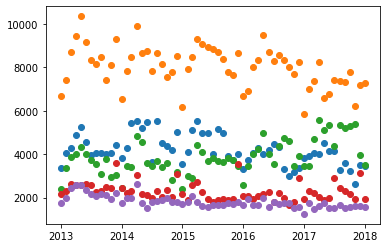

In [90]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_06','SKU_01'])

plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_06','SKU_02'])

plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_06','SKU_03'])

plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_06','SKU_04'])

plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_06','SKU_05'])

plt.show()

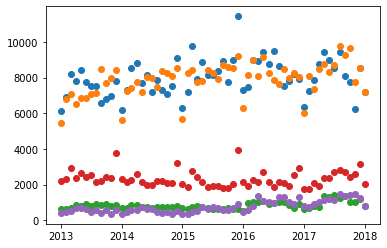

In [88]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_14','SKU_01'])

plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_14','SKU_02'])

plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_14','SKU_03'])

plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_14','SKU_04'])
plt.scatter(x=pivot_agen.index,
            y=pivot_agen['Agency_14','SKU_05'])

plt.show()

In [79]:
sku_recom = pd.read_csv('/content/sku_recommendation.csv')
tes = pivot_agen.loc['2018-01-01',:].reset_index()
tes.columns = ['Agency','SKU','Volume']
tes_1 = tes[tes.Agency=='Agency_06']
tes_2 = tes[tes.Agency=='Agency_14']
tes_3 = list(tes_1.loc[tes_1['Volume'].nlargest(2).index,'SKU']) + list(tes_2.loc[tes_2['Volume'].nlargest(2).index,'SKU'])
sku_recom.SKU = tes_3
print(sku_recom)

      Agency     SKU
0  Agency_06  SKU_02
1  Agency_06  SKU_03
2  Agency_14  SKU_02
3  Agency_14  SKU_01
